In [51]:
import pandas as pd
book = pd.read_excel(r"C:\Users\venna\Downloads\Train-dataset.xlsx")
book.head()
#book.shape


,City,State,Type,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,SWM,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors,Covid Cases
0,Mumbai,Maharashtra,M.C,12442373.0,11978450.0,878.0,23.0,32.0,MEDIUM,219.0,150.0,0.700440,10924403.0,159.0,4408916.0,163115
1,Delhi,Delhi,M.C,11007835.0,9879172.0,858.0,27.0,30.0,MEDIUM,215.0,196.0,0.920018,9444722.0,148.0,2379169.0,80188
2,Bangalore,Karnataka,MPUA,8436675.0,4301326.0,936.0,28.0,37.0,HIGH,212.0,102.0,0.097085,7896728.0,123.0,636502.0,141000
3,Hyderabad,Telangana,MPUA,6809970.0,3637483.0,930.0,23.0,31.0,MEDIUM,217.0,118.0,0.827744,6333272.0,110.0,126078.0,55123
4,Ahmedabad,Gujarat,MPUA,5570585.0,3520085.0,852.0,29.0,25.0,LOW,227.0,109.0,0.847941,4746138.0,73.0,284973.0,33204


In [33]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\venna\anaconda3\python.exe -m pip install --upgrade pip' command.


In [40]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\venna\anaconda3\python.exe -m pip install --upgrade pip' command.


In [42]:
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [95]:
test = pd.read_excel(r"C:\Users\venna\Downloads\Train-dataset.xlsx")
train = pd.read_excel(r"C:\Users\venna\Downloads\Test-dataset.xlsx")
#train.Province_State.fillna("None", inplace=True)
train["Covid_Cases"] = test["Covid Cases"]
display(train["State"])
display(train.describe())
print("Number of State_Region: ", train['State'].nunique())

0           Nagaland
1          Karnataka
2             Punjab
3        Maharashtra
4      Uttar Pradesh
           ...      
496      Uttarakhand
497      Uttarakhand
498      Uttarakhand
499      Uttarakhand
500    Uttar Pradesh
Name: State, Length: 501, dtype: object

,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors,Covid_Cases
count,495.000000,0.0,496.000000,488.000000,487.000000,479.000000,482.000000,486.000000,486.000000,484.000000,4.840000e+02,501.000000
mean,24747.468687,NaN,895.508065,26.120902,29.100616,72.277662,151.358921,0.501042,22542.633745,19.173554,1.676301e+06,8983.431138
std,7813.067500,NaN,38.464150,2.145559,9.295788,20.799002,28.719191,0.284300,6931.232314,6.697149,1.704860e+06,18494.033019
min,110.000000,NaN,774.000000,23.000000,5.000000,10.000000,100.000000,0.000957,0.000000,3.000000,7.980000e+02,358.000000
25%,21435.000000,NaN,867.750000,24.000000,26.000000,61.000000,127.000000,0.266619,19449.750000,14.000000,2.849730e+05,2436.000000
50%,25199.000000,NaN,890.500000,26.000000,31.000000,74.000000,152.000000,0.508218,22998.500000,20.000000,9.237370e+05,5840.000000
75%,30763.000000,NaN,922.000000,28.000000,36.000000,90.000000,175.000000,0.737776,27701.750000,25.000000,3.104060e+06,9779.000000
max,36774.000000,NaN,991.000000,32.000000,40.000000,100.000000,200.000000,0.999901,34523.000000,30.000000,4.684707e+06,218502.000000


Number of State_Region:  29


Text(0.5, 0, 'States')

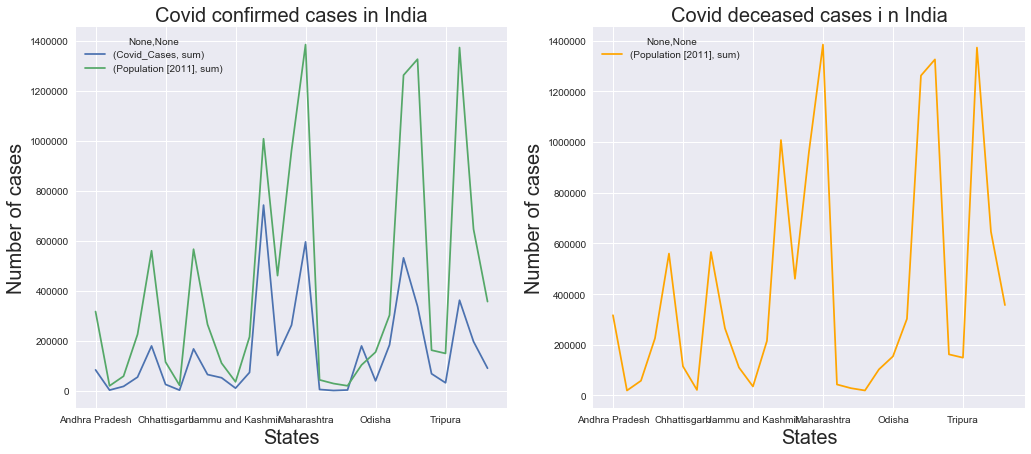

In [80]:
confirmed_total_date = train.groupby(['State']).agg({'Covid_Cases':['sum']})
fatalities_total_date = train.groupby(['State']).agg({'Population [2011]':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Covid confirmed cases in India", size=20)
ax1.set_ylabel("Number of cases", size=20)
ax1.set_xlabel("States", size=20)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Covid deceased cases i n India", size=20)
ax2.set_ylabel("Number of cases", size=20)
ax2.set_xlabel("States", size=20)

In [70]:
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [72]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [73]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

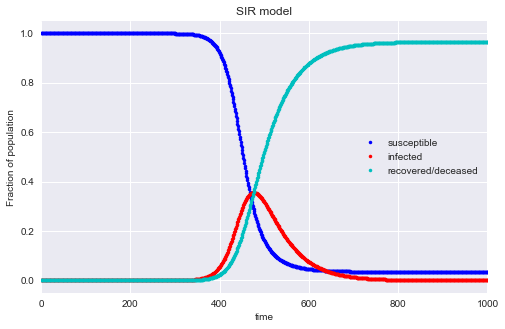

In [74]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

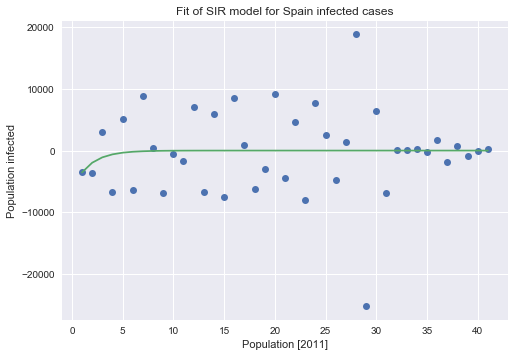

Optimal parameters: beta = 0.07063905290104078  and gamma =  0.6556779392741255


In [100]:
population = float(12442373)
country_df = pd.DataFrame()
country_df['Covid_Cases'] = train.loc[train['State'] == 'Maharashtra'].Covid_Cases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.Covid_Cases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Population [2011]")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [125]:
all_data = pd.concat([train, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases
# Fill null values given that we merged train-test datasets
all_data['State'].fillna("None", inplace=True)
all_data['Covid Cases'].fillna(0, inplace=True)
all_data['Covid_Cases'].fillna(0,inplace = True)
all_data['City'].fillna(0, inplace=True)
all_data['Type'].fillna(-1, inplace=True)
all_data['SWM'].fillna(-1, inplace=True)
all_data['Popuation [2001]'].fillna(0,inplace = True)
all_data['Population [2011]'].fillna(0,inplace = True)
all_data['Sex Ratio'].fillna(-1, inplace=True)
all_data['Avg Temp'].fillna(-1, inplace=True)
all_data['Median Age'].fillna(-1, inplace=True)
all_data['Water Purity'].fillna(0,inplace = True)
all_data['H Index'].fillna(0,inplace = True)
all_data['Female Population'].fillna(0,inplace = True)
all_data['# of hospitals'].fillna(0,inplace = True)
all_data['Foreign Visitors'].fillna(0,inplace = True)
all_data['Toilets Avl'].fillna(0,inplace = True)
display(all_data)
display(all_data.loc[all_data['City'] == 'Delhi'])

,City,State,Type,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,SWM,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors,Covid_Cases,Covid Cases
0,Tuensang,Nagaland,T.C,36774.0,0.0,931.0,23.0,10.0,MEDIUM,94.0,114.0,0.253390,34237.0,17.0,2769.0,163115.0,0.0
1,Lakshmeshwar,Karnataka,T.M.C,36754.0,0.0,934.0,25.0,38.0,HIGH,62.0,160.0,0.192555,34328.0,13.0,636502.0,80188.0,0.0
2,Zira,Punjab,M.Cl.,36732.0,0.0,883.0,29.0,35.0,HIGH,63.0,105.0,0.887882,32434.0,17.0,242367.0,141000.0,0.0
3,Yawal,Maharashtra,M.Cl,36706.0,0.0,887.0,26.0,31.0,HIGH,60.0,174.0,0.407838,32558.0,11.0,4408916.0,55123.0,0.0
4,Thana Bhawan,Uttar Pradesh,N.P.,36669.0,0.0,877.0,28.0,39.0,LOW,92.0,153.0,0.324456,32159.0,23.0,3104060.0,33204.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,Lunawada,Gujarat,M,36954.0,0.0,846.0,23.0,28.0,MEDIUM,68.0,103.0,0.035280,31263.0,19.0,284973.0,0.0,1944.0
783,Murshidabad,West Bengal,M,36947.0,0.0,945.0,23.0,36.0,MEDIUM,62.0,136.0,0.056394,34915.0,22.0,1489500.0,0.0,2172.0
784,Mahe,Puducherry,M,36828.0,0.0,1019.0,28.0,28.0,HIGH,98.0,138.0,0.066752,37528.0,27.0,106153.0,0.0,2851.0
785,Lanka,Assam,M.B,36805.0,0.0,900.0,24.0,6.0,MEDIUM,63.0,145.0,0.627556,33125.0,15.0,24720.0,0.0,2158.0


,City,State,Type,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,SWM,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors,Covid_Cases,Covid Cases
1,Delhi,Delhi,M.C,11007835.0,9879172.0,858.0,27.0,30.0,MEDIUM,215.0,196.0,0.920018,9444722.0,148.0,2379169.0,0.0,80188.0


In [126]:
all_data.isnull().sum()

City                 0
State                0
Type                 0
Population [2011]    0
Popuation [2001]     0
Sex Ratio            0
Median Age           0
Avg Temp             0
SWM                  0
Toilets Avl          0
Water Purity         0
H Index              0
Female Population    0
# of hospitals       0
Foreign Visitors     0
Covid_Cases          0
Covid Cases          0
dtype: int64

{23: 23, 16: 16, 26: 26, 19: 19, 33: 33, 31: 31, 27: 27, 35: 35, 3: 3, 15: 15, 18: 18, 1: 1, 14: 14, 29: 29, 11: 11, 13: 13, 34: 34, 5: 5, 17: 17, 24: 24, 12: 12, 32: 32, 7: 7, 4: 4, 21: 21, 20: 20, 8: 8, 22: 22, 2: 2, 9: 9, 30: 30, 6: 6, 25: 25, 28: 28, 0: 0, 10: 10}


Text(0, 0.5, 'Log ConfirmedCases')

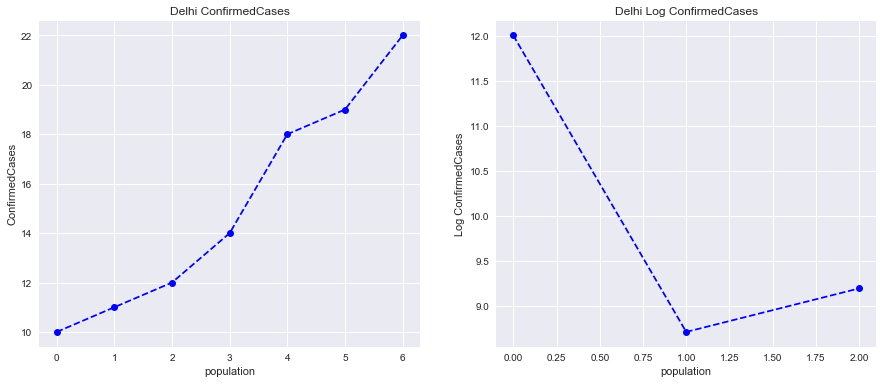

In [165]:
le = preprocessing.LabelEncoder()
#all_data['Day_num'] = le.fit_transform(all_data.Covid_Cases)
all_data['State'] = le.fit_transform(all_data['State'])
number_c = all_data['State']
states = le.inverse_transform(all_data['State'])
country_dict = dict(zip(states, number_c)) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
print(country_dict)

# Day_num = 38 is March 1st
#y1 = all_data[(all_data['State'] == country_dict[23])]
y1 = [10,11,12,14,18,19,22]
tuple(np.ndarray(y1))
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Delhi ConfirmedCases")
ax1.set_xlabel("population")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['State']==country_dict[23])][['Covid_Cases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Delhi Log ConfirmedCases")
ax2.set_xlabel("population")
ax2.set_ylabel("Log ConfirmedCases")

In [ ]:
def logistic_function(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def fit_logistic(all_data,country_name,city, train_lim, target):
    data_cp = all_data.loc[(all_data['State']==country_dict[country_name])]
    y = data_cp.loc[(data_cp['Covid_Cases'])<=train_lim, target].astype(np.int32)
    x = list(range(0, len(y)))

    # Initial guess
    p0 = [0,1,1,0]

    (a_, b_, c_, d_), cov = optimize.curve_fit(logistic_function, x, y, bounds=(0, [500000., 10., 1000., 1000., ]), p0=p0, maxfev=10**9)
    y_fit = logistic_function(x, a_, b_, c_, d_)
    
    return x, y, y_fit, (a_, b_, c_, d_), cov

def plot_logistic(x, y, y_fit, country_name, province_name, target):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(x, y, 'o')
    ax.plot(x, y_fit, '-')
    ax.set_xlabel("Covid Cases")
    ax.set_ylabel(target)
    ax.set_title("Fit to logistic regression for "+ str(country_name)+"/")
    

def plot_logistic_country(all_data, train, country_name, province_name, valid_num, target, x, a_, b_, c_, d_):
    forecast = logistic_function(list(range(len(x)+60)), a_, b_, c_, d_)
    df_train = train.loc[(train['State']==country_name) & (train['City']==province_name), target]
    df_fcst = forecast[:len(df_train)]
    dates = list(range(0,len(df_train)))
    
    # Plot results
    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    ax1.plot(dates, df_fcst)
    ax1.plot(dates, df_train)
    ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.set_title("Actual ConfirmedCases vs predictions based on Logistic curve for "+str(country_name)+ "/"+province_name)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("population")
    ax1.set_ylabel("ConfirmedCases")


# Fit country to logistic curve
country_name = 23
province_name = 'None'
train_lim = 23
valid_lim = 54 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 
x, y, y_fit, (a_, b_, c_, d_), cov = fit_logistic(all_data, country_name, province_name, train_lim, 'Covid_Cases')
plot_logistic(x, y, y_fit, country_name, province_name, 'Covid_Cases')
plot_logistic_country(all_data, train, country_name, province_name, valid_num, 'Covid_Cases', x, a_, b_, c_, d_)
